# Segmentation Tutorial: Classical Methods + UNet (Quick)

This tutorial combines basic classical image segmentation techniques with a minimal UNet training/inference workflow on the NuInsSeg dataset contained in this repository. It is designed to run training for only 1 epoch on a small subset.

What you'll do:
- Explore classical segmentation: grayscale, Otsu thresholding, simple morphology, Sobel edges.
- Train a small UNet for 1 epoch on a limited subset.
- Load a pretrained checkpoint (if available under `runs/`) and run inference.

Notes:
- Data: this uses the `NuInsSeg/` tree (e.g., `human spleen/tissue images` + `
mask binary`).
- Keep the subset size small (`LIMIT`) and the image size moderate (`IMG_SIZE`).
- GPU is recommended but not required.


In [ ]:
# Setup 1: Setup - Clone Repository (for Colab/Kaggle)
import os
import subprocess
import sys

# Check if we're in Colab or need to clone
if not os.path.exists('train_unet'):
    print("Cloning repository...")
    subprocess.run(['git', 'clone', 'https://github.com/KikuchiJun1/MicroTas-2025-Workshop-9-Segmentation.git', 'segmentation_repo'], check=True)
    os.chdir('segmentation_repo')
    print("Repository cloned successfully!")
    print(f"Current directory: {os.getcwd()}")
else:
    print("Repository already cloned. Skipping...")

In [ ]:
# Setup 2: Import Required Libraries
import random, time
from PIL import Image, ImageFilter, ImageOps
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

from train_unet.dataset_nuinsseg import discover_pairs, NuInsSegDataset
from train_unet.transforms import build_transforms
from train_unet.model_unet import UNet
from train_unet.utils import set_seed, bce_dice_loss, dice_coeff, iou_score, AverageMeter, ensure_dir, count_parameters

print("All libraries imported successfully!")

In [ ]:
# Setup 3: Configuration & Download Pretrained Weights
set_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

# Configuration
DATA_ROOT = 'NuInsSeg'
INCLUDE = ['human_spleen']  # change to focus another subset
IMG_SIZE = 256
LIMIT = 40      # total pairs used (keep small for speed)
VAL_FRAC = 0.2
TEST_FRAC = 0.1
BATCH_SIZE = 4
EPOCHS = 10
OUTDIR = 'runs/tutorial_classical_unet'
ensure_dir(OUTDIR)



In [ ]:
# Stepup 4: Download Pretrained Weights
import urllib.request

WEIGHTS_URL = 'https://drive.google.com/uc?export=download&id=1tjfTRYWWf1OlsHml1-DltZuIA6O71_ro'
WEIGHTS_PATH = os.path.join(OUTDIR, 'best.pt')

if not os.path.exists(WEIGHTS_PATH):
    print("Downloading pretrained weights from Google Drive...")
    try:
        urllib.request.urlretrieve(WEIGHTS_URL, WEIGHTS_PATH)
        print(f"✓ Weights downloaded successfully to {WEIGHTS_PATH}")
    except Exception as e:
        print(f"⚠ Warning: Could not download weights: {e}")
else:
    print(f"✓ Weights already exist at {WEIGHTS_PATH}")

print("\nSetup complete! Ready to start segmentation tutorial.")

In [ ]:
# Helper functions: visualization, Otsu threshold, Sobel edges, simple morphology
import math

def to_gray_uint8(pil_img):
    return np.asarray(pil_img.convert('L'), dtype=np.uint8)

def overlay_mask(rgb_img, mask, color=(255, 0, 0), alpha=0.4):
    if isinstance(rgb_img, Image.Image):
        base = np.asarray(rgb_img.convert('RGB')).copy()
    else:
        base = np.asarray(rgb_img).copy()
    m = (mask > 0)
    overlay = np.zeros_like(base)
    overlay[m] = np.array(color, dtype=np.uint8)
    out = (base * (1 - alpha) + overlay * alpha).clip(0, 255).astype(np.uint8)
    return out

def show_triplet(img, pred_mask, gt_mask, title=''):
    plt.figure(figsize=(12, 4))
    plt.subplot(1,3,1); plt.imshow(img); plt.axis('off'); plt.title('Image')
    plt.subplot(1,3,2); plt.imshow(pred_mask, cmap='gray'); plt.axis('off'); plt.title('Prediction')
    plt.subplot(1,3,3); plt.imshow(gt_mask, cmap='gray'); plt.axis('off'); plt.title('Ground Truth')
    if title: plt.suptitle(title)
    plt.show()

def otsu_threshold(gray_uint8):
    # gray_uint8: HxW in [0..255]
    hist = np.bincount(gray_uint8.ravel(), minlength=256).astype(np.float64)
    p = hist / (hist.sum() + 1e-12)
    omega = np.cumsum(p)
    mu = np.cumsum(p * np.arange(256))
    mu_t = mu[-1]
    denom = (omega * (1.0 - omega))
    denom[denom == 0] = np.nan
    sigma_b2 = (mu_t * omega - mu)**2 / denom
    t = int(np.nanargmax(sigma_b2))
    return t

def _to_tensor01(x):
    return torch.from_numpy(x.astype(np.float32))[None, None]  # [1,1,H,W]

def dilate_bin(mask_uint8, k=3, iters=1):
    x = _to_tensor01(mask_uint8)
    for _ in range(max(1, iters)):
        x = torch.nn.functional.max_pool2d(x, kernel_size=k, stride=1, padding=k//2)
    return (x.squeeze().numpy() > 0.5).astype(np.uint8)

def erode_bin(mask_uint8, k=3, iters=1):
    x = _to_tensor01(mask_uint8)
    for _ in range(max(1, iters)):
        x = -torch.nn.functional.max_pool2d(-x, kernel_size=k, stride=1, padding=k//2)
    return (x.squeeze().numpy() > 0.5).astype(np.uint8)

def open_bin(mask_uint8, k=3, iters=1):
    return dilate_bin(erode_bin(mask_uint8, k, iters), k, iters)

def close_bin(mask_uint8, k=3, iters=1):
    return erode_bin(dilate_bin(mask_uint8, k, iters), k, iters)

def compute_metrics(pred_mask_uint8, gt_mask_uint8):
    p = torch.from_numpy(pred_mask_uint8.astype(np.float32))[None, None]
    t = torch.from_numpy(gt_mask_uint8.astype(np.float32))[None, None]
    with torch.no_grad():
        logits = p  # {0,1} is fine for these metrics
        d = dice_coeff(logits, t).item()
        i = iou_score(logits, t).item()
    return d, i

def split_pairs_threeway(pairs, val_frac, test_frac, seed=42):
    if val_frac + test_frac >= 1.0:
        raise ValueError('val_frac + test_frac must be < 1.0')
    n = len(pairs)
    rng = random.Random(seed)
    idxs = list(range(n)); rng.shuffle(idxs)
    n_test = int(n * test_frac)
    n_val = int(n * val_frac)
    if test_frac > 0 and n_test == 0 and n >= 1: n_test = 1
    if val_frac > 0 and n_val == 0 and n - n_test >= 1: n_val = 1
    test_idx = set(idxs[:n_test])
    val_idx = set(idxs[n_test:n_test+n_val])
    train = [pairs[i] for i in idxs if i not in test_idx and i not in val_idx]
    val = [pairs[i] for i in val_idx]
    test = [pairs[i] for i in test_idx]
    return train, val, test

def collate_batch(batch):
    imgs = torch.stack([b.image for b in batch], dim=0)
    msks = torch.stack([b.mask for b in batch], dim=0)
    paths = [(b.img_path, b.msk_path) for b in batch]
    return imgs, msks, paths


Found 34 image/mask pairs (limited).
Train: 25 | Val: 6 | Test: 3


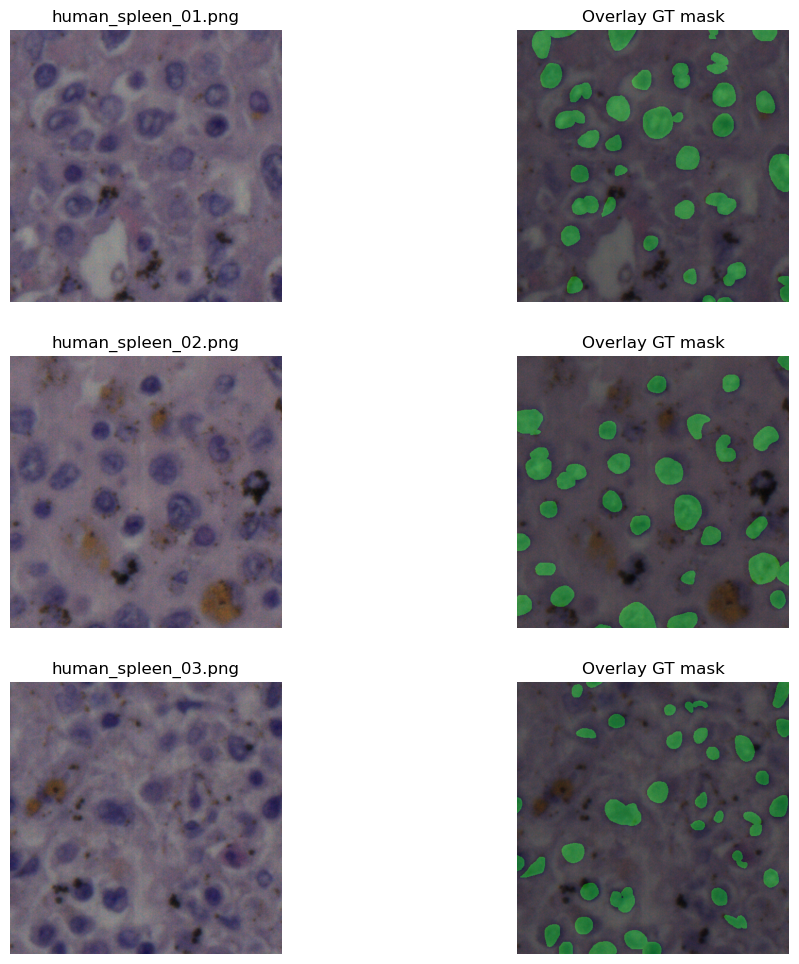

In [3]:
# Discover pairs and preview
pairs = discover_pairs(DATA_ROOT, include=INCLUDE)
if LIMIT and LIMIT > 0 and len(pairs) > LIMIT:
    pairs = pairs[:LIMIT]
print(f'Found {len(pairs)} image/mask pairs (limited).')

train_pairs, val_pairs, test_pairs = split_pairs_threeway(pairs, VAL_FRAC, TEST_FRAC, seed=42)
print(f'Train: {len(train_pairs)} | Val: {len(val_pairs)} | Test: {len(test_pairs)}')

# Preview a few samples
num_preview = min(3, len(pairs))
plt.figure(figsize=(12, 4*num_preview))
for i in range(num_preview):
    img_p, msk_p = pairs[i]
    img = Image.open(img_p).convert('RGB')
    msk = (np.asarray(Image.open(msk_p).convert('L')) > 0).astype(np.uint8)
    over = overlay_mask(img, msk*255, color=(0,255,0), alpha=0.35)
    plt.subplot(num_preview, 2, 2*i+1); plt.imshow(img); plt.axis('off'); plt.title(os.path.basename(img_p))
    plt.subplot(num_preview, 2, 2*i+2); plt.imshow(over); plt.axis('off'); plt.title('Overlay GT mask')
plt.show()


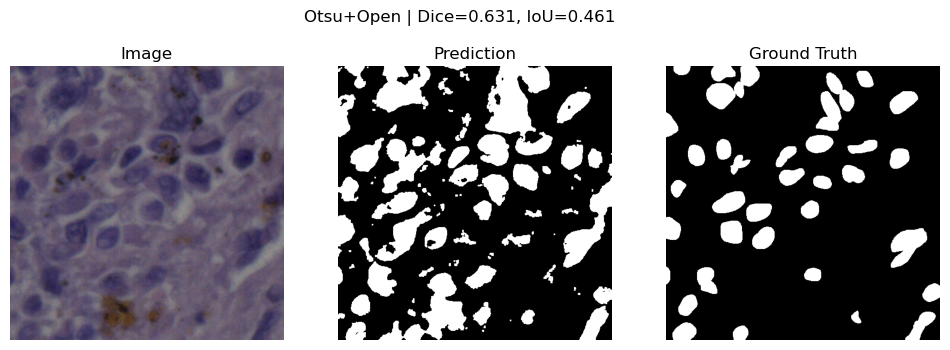

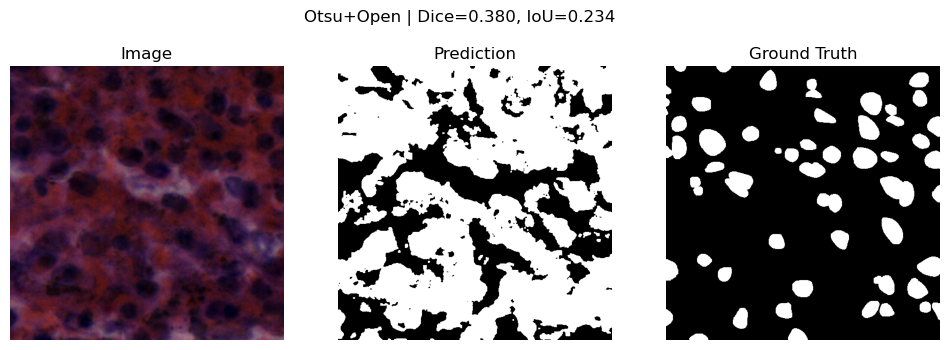

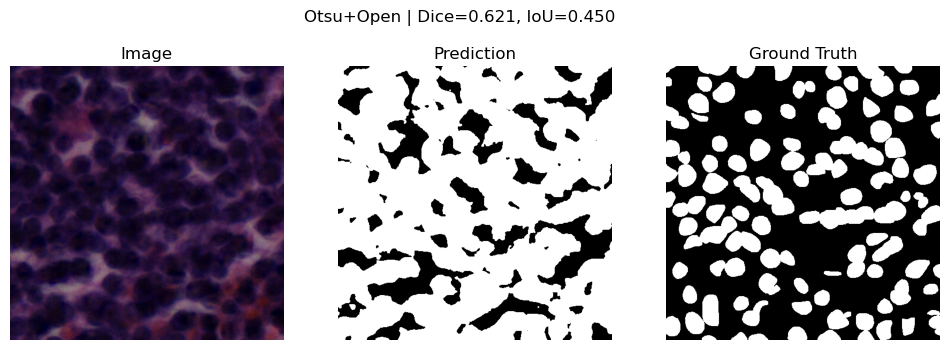

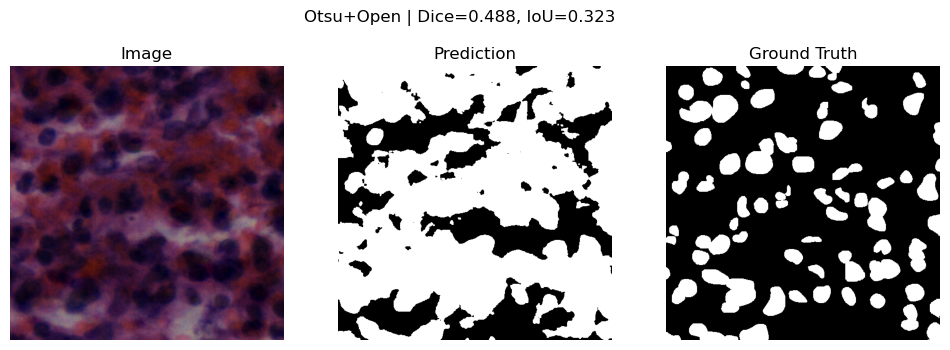

Classical (Otsu+Open) on 4 samples -> Dice=0.530, IoU=0.367


In [7]:
# Classical method 1: Otsu threshold + morphology
val_eval = []
n_demo = min(4, len(val_pairs))
for i in range(n_demo):
    img_p, msk_p = val_pairs[i]
    img = Image.open(img_p).convert('RGB')
    gt = (np.asarray(Image.open(msk_p).convert('L')) > 0).astype(np.uint8)
    # slight blur to denoise before thresholding
    img_blur = img.filter(ImageFilter.GaussianBlur(radius=1))
    gray = to_gray_uint8(img_blur)
    t = otsu_threshold(gray)
    pred = (gray < t).astype(np.uint8) 
    # small opening to remove speckles
    pred = open_bin(pred, k=3, iters=1)
    d, iou = compute_metrics(pred, gt)
    val_eval.append((d, iou))
    show_triplet(img, pred*255, gt*255, title=f'Otsu+Open | Dice={d:.3f}, IoU={iou:.3f}')

if val_eval:
    md = float(np.mean([x[0] for x in val_eval]))
    mi = float(np.mean([x[1] for x in val_eval]))
    print(f'Classical (Otsu+Open) on {len(val_eval)} samples -> Dice={md:.3f}, IoU={mi:.3f}')
else:
    print('No validation pairs to demo classical method.')


UNet (base_ch=16) params: 838785
Epoch 1/10 | Train 0.8088 | Val 0.7334 | Dice 0.0093 | IoU 0.0047
Saved best checkpoint to runs/tutorial_classical_unet/best.pt
Epoch 2/10 | Train 0.5248 | Val 1.0358 | Dice 0.0923 | IoU 0.0486
Saved best checkpoint to runs/tutorial_classical_unet/best.pt
Epoch 3/10 | Train 0.4517 | Val 0.6068 | Dice 0.3003 | IoU 0.1907
Saved best checkpoint to runs/tutorial_classical_unet/best.pt
Epoch 4/10 | Train 0.4060 | Val 0.7313 | Dice 0.0295 | IoU 0.0150
Epoch 5/10 | Train 0.3800 | Val 0.6137 | Dice 0.2320 | IoU 0.1428
Epoch 6/10 | Train 0.3865 | Val 0.5548 | Dice 0.4393 | IoU 0.3040
Saved best checkpoint to runs/tutorial_classical_unet/best.pt
Epoch 7/10 | Train 0.3618 | Val 0.4324 | Dice 0.6333 | IoU 0.4924
Saved best checkpoint to runs/tutorial_classical_unet/best.pt
Epoch 8/10 | Train 0.3807 | Val 0.4752 | Dice 0.6764 | IoU 0.5159
Saved best checkpoint to runs/tutorial_classical_unet/best.pt
Epoch 9/10 | Train 0.3467 | Val 0.4098 | Dice 0.6952 | IoU 0.5394
S

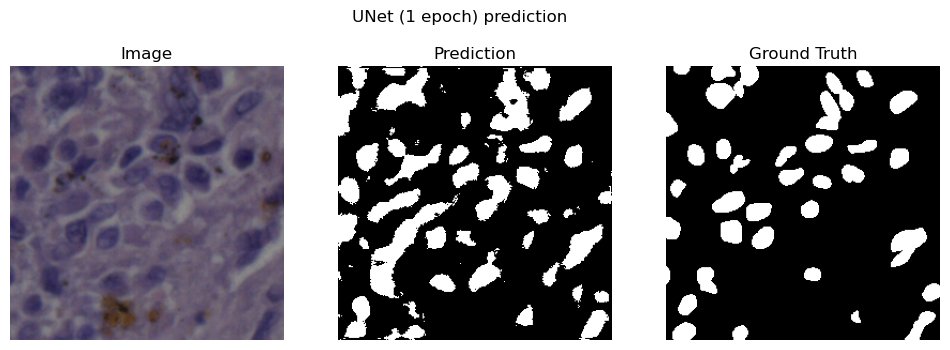

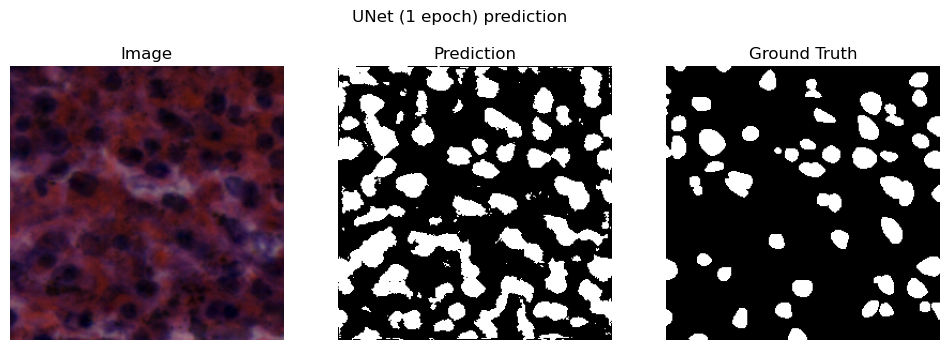

In [ ]:
# UNet training (1 epoch, small model + subset)
train_t, val_t = build_transforms(IMG_SIZE, augment=True)
train_ds = NuInsSegDataset(train_pairs, transform=train_t, img_size=IMG_SIZE)
val_ds = NuInsSegDataset(val_pairs, transform=val_t, img_size=IMG_SIZE)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True, collate_fn=collate_batch)
val_loader = DataLoader(val_ds, batch_size=max(1, BATCH_SIZE//2), shuffle=False, num_workers=2, pin_memory=True, collate_fn=collate_batch)

model_small = UNet(n_channels=3, n_classes=1, base_ch=16).to(device)
print('UNet (base_ch=16) params:', count_parameters(model_small))
opt = torch.optim.Adam(model_small.parameters(), lr=1e-3)
best_dice = -1.0

for epoch in range(EPOCHS):
    model_small.train()
    train_loss = AverageMeter()
    for step, (imgs, msks, _) in enumerate(train_loader, 1):
        imgs = imgs.to(device, non_blocking=True)
        msks = msks.to(device, non_blocking=True)
        opt.zero_grad(set_to_none=True)
        logits = model_small(imgs)
        loss = bce_dice_loss(logits, msks)
        loss.backward()
        opt.step()
        train_loss.update(loss.item(), imgs.size(0))
        if step % 10 == 0:
            print(f'Epoch {epoch+1} Step {step}/{len(train_loader)} | Loss {train_loss.avg:.4f}')

    # Validation
    model_small.eval()
    val_loss = AverageMeter(); val_dice = AverageMeter(); val_iou = AverageMeter()
    with torch.no_grad():
        for imgs, msks, _ in val_loader:
            imgs = imgs.to(device, non_blocking=True)
            msks = msks.to(device, non_blocking=True)
            logits = model_small(imgs)
            loss = bce_dice_loss(logits, msks)
            val_loss.update(loss.item(), imgs.size(0))
            val_dice.update(dice_coeff(logits, msks).item(), imgs.size(0))
            val_iou.update(iou_score(logits, msks).item(), imgs.size(0))
    print(f'Epoch {epoch+1}/{EPOCHS} | Train {train_loss.avg:.4f} | Val {val_loss.avg:.4f} | Dice {val_dice.avg:.4f} | IoU {val_iou.avg:.4f}')

    # Save best
    if val_dice.avg > best_dice:
        best_dice = val_dice.avg
        torch.save({'epoch': epoch+1, 'model': model_small.state_dict()}, os.path.join(OUTDIR, 'best.pt'))
        print('Saved best checkpoint to', os.path.join(OUTDIR, 'best.pt'))

# Show a couple validation predictions
model_small.eval()
n_show = min(2, len(val_ds))
with torch.no_grad():
    for i in range(n_show):
        s = val_ds[i]
        img_t = s.image.unsqueeze(0).to(device)
        logits = model_small(img_t)
        prob = torch.sigmoid(logits)[0,0].cpu().numpy()
        pred = (prob >= 0.5).astype(np.uint8)
        rgb = (s.image.clamp(0,1).cpu().permute(1,2,0).numpy()*255).astype(np.uint8)
        gt = s.mask[0].cpu().numpy().astype(np.uint8)
        show_triplet(rgb, pred*255, gt*255, title='UNet (10 epoch) prediction')


Checkpoint candidate: runs/expD2/best.pt


/tmp/ipykernel_177919/1440100556.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load(ckpt_path, map_location='cpu')


Loaded pretrained checkpoint with base_ch=64
Running inference on 3 images...


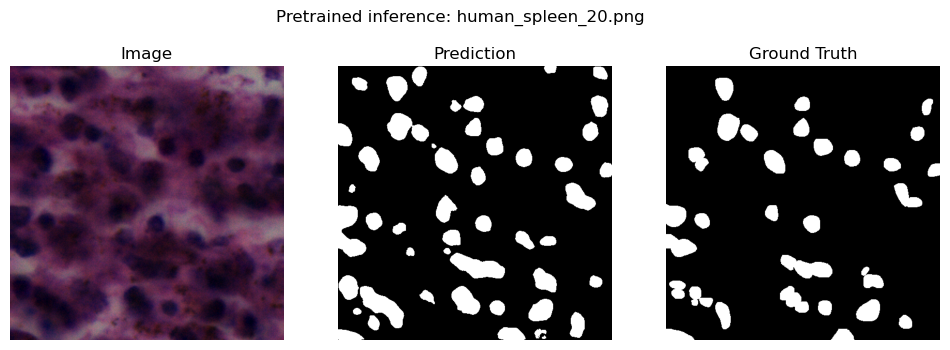

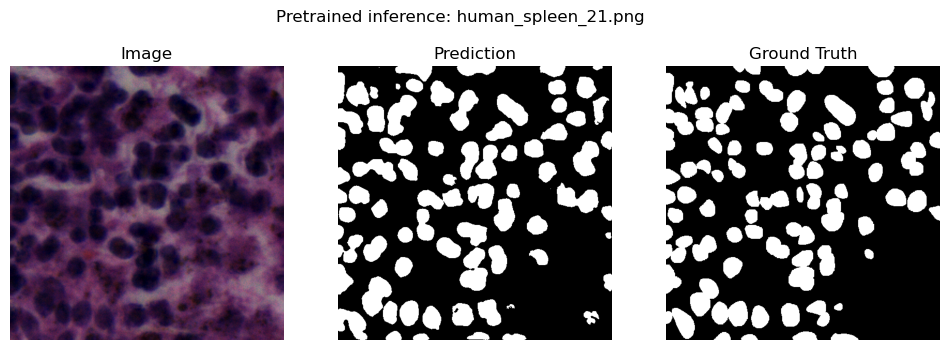

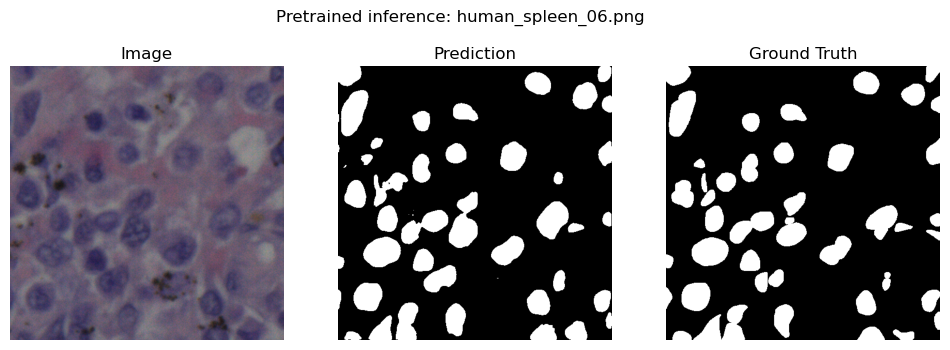

In [ ]:
# Pretrained inference: load an existing checkpoint under runs/ if available
ckpt_candidates = [
    os.path.join('runs','expD2','best.pt'),
]
ckpt_path = next((p for p in ckpt_candidates if os.path.isfile(p)), None)
print('Checkpoint candidate:', ckpt_path)

if ckpt_path is None:
    print('No checkpoint found; skipping pretrained inference.')
else:
    sd = torch.load(ckpt_path, map_location='cpu')
    sd = sd.get('model', sd)
    loaded = False
    for base in [64, 32, 16]:
        model_pre = UNet(n_channels=3, n_classes=1, base_ch=base).to(device)
        try:
            model_pre.load_state_dict(sd, strict=True)
            print(f'Loaded pretrained checkpoint with base_ch={base}')
            loaded = True
            break
        except Exception as e:
            print(f'Could not load with base_ch={base}:', str(e)[:120])
    if not loaded:
        print('Falling back to the 1-epoch model for inference.')
        model_pre = model_small
    
    model_pre.eval()
    # Use test set if available; otherwise some val pairs
    sample_pairs = test_pairs if len(test_pairs) > 0 else val_pairs
    n_infer = min(6, len(sample_pairs))
    print(f'Running inference on {n_infer} images...')
    for i in range(n_infer):
        img_p, msk_p = sample_pairs[i]
        img = Image.open(img_p).convert('RGB')
        gt = (np.asarray(Image.open(msk_p).convert('L')) > 0).astype(np.uint8)
        img_t = torch.from_numpy(np.asarray(img, dtype=np.uint8)).float().permute(2,0,1)/255.0
        with torch.no_grad():
            logits = model_pre(img_t.unsqueeze(0).to(device))
            prob = torch.sigmoid(logits)[0,0].cpu().numpy()
        pred = (prob >= 0.5).astype(np.uint8)
        show_triplet(img, pred*255, gt*255, title=f'Pretrained inference: {os.path.basename(img_p)}')
